In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

import sys
sys.path.append('..')
from utils import preprocess, missing, evaluate

### Global Variables and Load Data

In [2]:
target = 'SI.POV.DDAY'
predict_year=2010
#percent of input Indicators to use (set to 100 for full set of input features)
percent = 1

In [3]:
#Load the data from disk
input_dir = '.\\..\\data\\'
data_input = "cleaned_data.pkl"
data = pd.read_pickle(input_dir + data_input)

#Possible subset of data choosen to reduce calulation time
#For percetages less than 100% we try to choose a subset that represents the spread of variables

if percent == 100:
    pass
else: 
    num_indicators_original = data.shape[1]
    step = int(100/percent)
    data_new = data.iloc[:,::step].copy()
    #Add the target column if not already included
    if target not in data_new.columns:
        data_new[target] = data[target]
    data = data_new
    
print(data.shape[1], "indicators included")

14 indicators included


### Multicountry plot across all 9 independent variables and the dependent variable (SI.POV.DDAY)

The following plot is a quick illustration of the state of data in across multiple coutries.

One thing that it clearly shows is that there is a strong correlation of location of missing values for many of the variables. However for some others, such as SI.POV.DDAY and SI.POV.GINI this is less the case. 

Secondly, it is clear that we will need a model that is robust to missing values.

A key question here is if these patterns help us know if we have to model each country seperately or if one model fits all. Is there a method that can help us to work this out? Maybe there is a middle ground of number of models (for example a different model for every continent.

There are a number of outlier countries that could be investigated as well. For example, in SE.PRM.UNER. What should be done with these? How should our respond to these outliers?

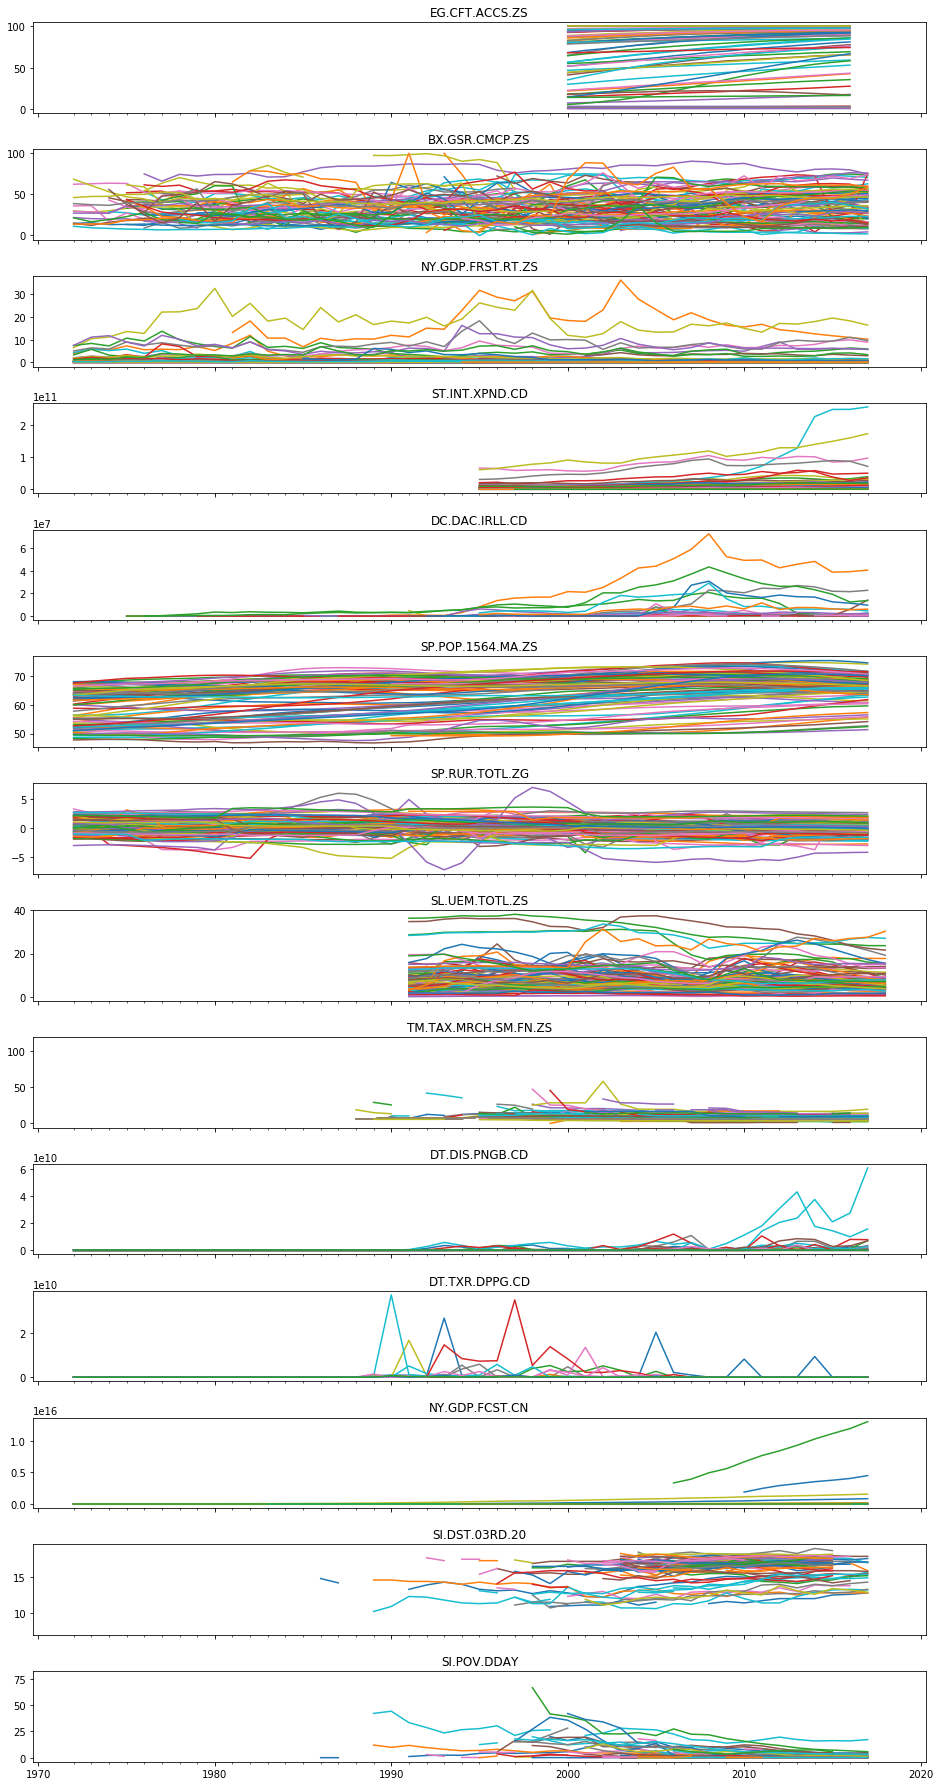

In [100]:
#Create a list of coutries to be plotted in the summary plot below
countries = list(data.index.levels[0])

#pyplot.figure(figsize=(16, 20))
inputs = list(data.iloc[:,:20].columns)

fig, axes = plt.subplots(len(inputs), 1, sharex=True ,figsize=(16, 32))

for i in range(len(inputs)):
    axes[i].set_xticks(list(range(1972,2018)), minor=True)
    axes[i].set_title(inputs[i])
    #ax.set_yticklabels([])
    column = inputs[i]
    for country in countries:
        values = data.loc[country][column].values
        axes[i].plot( list(range(1972,2019)), values)
plt.subplots_adjust(wspace=0, hspace=0.4)
#fig.invert_xaxis()
#pyplot.show()

### Missing Data Imputation

This represents a very first stab at imputation without any significance given to why the data is missing. Motivation right now is to get something working.   
The current approach is to do interpolation. Python is pretty poor on techniques for imputation of multivariate time domain data that accounts for both temporal and feature correlations.

Graph showing missing data for each indicator. White represents "missing" and grey represents "not missing".

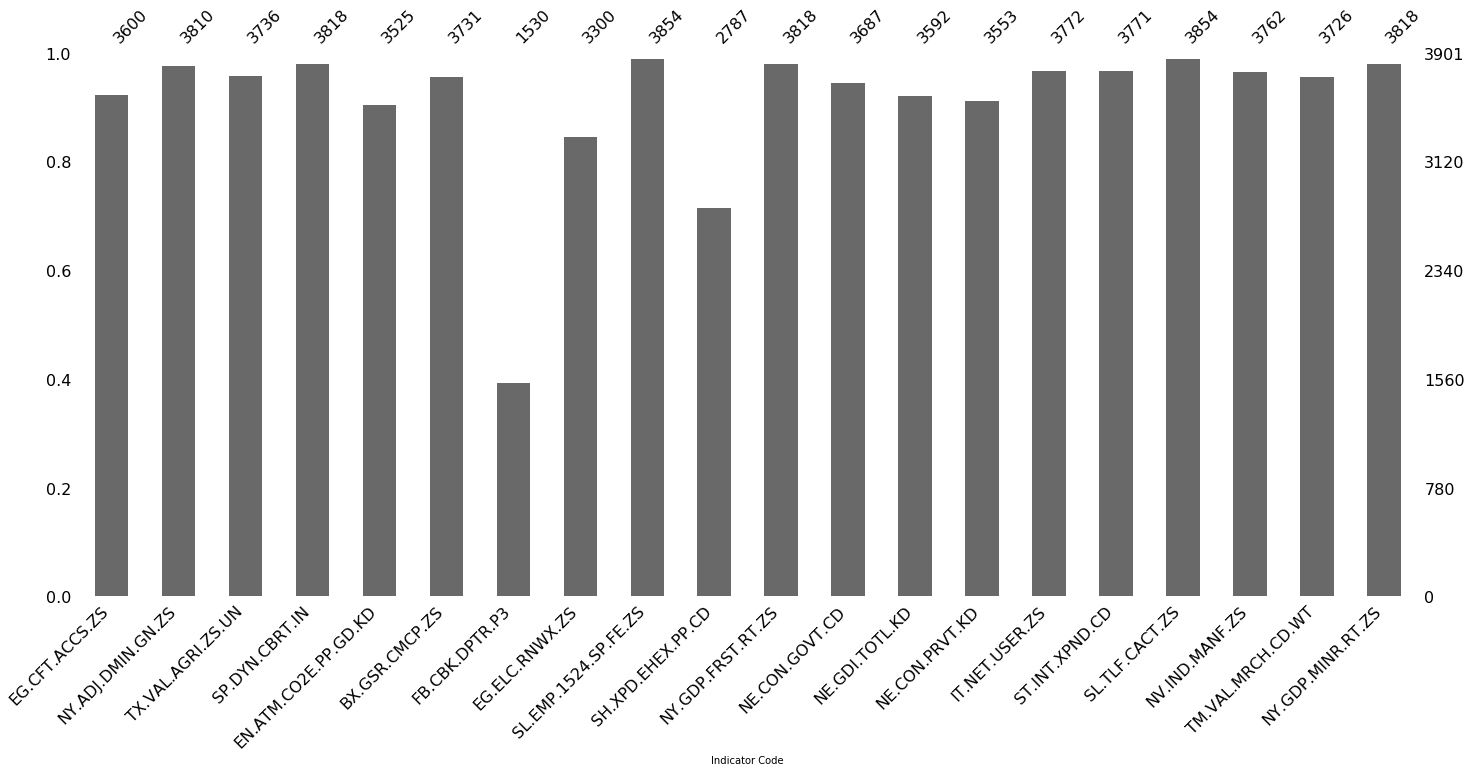

In [76]:
msno.bar(data.iloc[:,:20])

In [69]:
def impute_data_interpolation(data, upto_year):
    """
        
    """
    data_local = data.copy()
    
    for country in data.index.levels[0]:
        
        
        data_local.loc[(country):(country,str(upto_year)),:] = \
            data_local.loc[(country):(country,str(upto_year)),:].interpolate(method='linear' ,limit_direction='both').values  
    
    #Set remaining missing values to 0. (This should be replaced by mean imputation ASAP)
    idx = pd.IndexSlice
    data_local.loc[idx[:, :str(upto_year)], :] = data_local.loc[idx[:, :str(upto_year)], :].fillna(0) 
    
    return data_local

In [ ]:
'''
imputer = IterativeImputer(n_iter=8,min_value=0 ,initial_strategy='mean')

for country in data.index.levels[0]:
    print(country)
    data_imputed.loc[country] = imputer.fit_transform(data.loc[country])
    
or

x = mice.MICEData(data.loc['Argentina'], perturbation_method='Gausssian' )
'''

### Break data into windows

Break up input dataframe (countries/year as 2-level index and economic indicators as columns) into windowed dataframes for training and testing.

A windowed dataframe can be seen below. Each window row is a sliding window (of size 'lag') of the indictor data.

*Possible improvement: Refactor and create interface to windowed data that allows us to return only the data we need for specific purpose. Initialise with input dataframe and stores the windowed data. Can include imputation method as well.*

In [70]:
%time data_regressors, data_targets = \
        preprocess.window_data(data, lag=5,num_windows=10, step=1, predict_year=2010, \
                         target=target, impute_func=impute_data_interpolation)

Wall time: 11min 19s


In [71]:
#Break up into training and testing data.

idx = pd.IndexSlice
data_train_regressors = data_regressors.loc[idx[:,2:10],:]
data_train_targets = data_targets.loc[idx[:,2:10],:]
data_test_regressors = data_regressors.loc[idx[:,1],:]
data_test_targets= data_targets.loc[idx[:,1],:]

#### Example windowed data frame

### Postprocess windows

Here we deal with windows that do not have any target value. Note that in the windowed dataframe, every row is a window. Each window will act as an observation in the input to our machine learning algorithm.

In the case of the training data, we get rid of these windows (both in the regressor training dataframe and the target training dataframe).

*TODO: Investigate possibility of imputing missing target data. One lead is [here](https://www.analyticbridge.datasciencecentral.com/forum/topics/missing-values-in-target)*

In the case of the test data we also do the same, as without a target, it is impossible to evaluate the error in prediction.


In [72]:
#For Training, only consider windows that don't have a missing target as they offer nothing to training
#Therefore, remove those observations from both the training regressors and targets datasets.
data_train_regressors_subset = data_train_regressors[~np.isnan(list(data_train_targets.values.flatten()))]
data_train_targets_subset = data_train_targets[~np.isnan(list(data_train_targets.values.flatten()))]

#For testing, also remove windows with no target variable as it is impossible to measure preformance.
data_test_regressors_subset = data_test_regressors[~np.isnan(list(data_test_targets.values.flatten()))]
data_test_targets_subset = data_test_targets[~np.isnan(list(data_test_targets.values.flatten()))]


### Standardize

In [73]:
scaler = StandardScaler()
#Fit the scaler on the training data only
scaler.fit(data_train_regressors_subset)

data_train_regressors_std_array = scaler.transform(data_train_regressors_subset)
data_test_regressors_std_array = scaler.transform(data_test_regressors_subset)


C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  """
C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  


In [74]:
data_train_regressors_std = pd.DataFrame(data_train_regressors_std_array, index=data_train_regressors_subset.index, columns=data_train_regressors_subset.columns)
data_test_regressors_std = pd.DataFrame(data_test_regressors_std_array, index=data_test_regressors_subset.index, columns=data_test_regressors_subset.columns)


### Linear Regression Prediction 

#### Historical values of the target only

This is very much an naive predictor. If we are limited to only historical values of the target variable then there are well established time series forecasting methods that can be used such as ARIMA. 

In [75]:
model_target_only = LinearRegression()
model_target_only.fit(data_train_regressors_std.loc[:,target],data_train_targets_subset)
#Make predictions
predictions_target_only = model_target_only.predict(data_test_regressors_std.loc[:,target])

mse_target_only = mean_squared_error(data_test_targets_subset, predictions_target_only)
print("MSE of linear regression using historical target values only is:", mse_target_only)

MSE of linear regression using historical target values only is: 22.70251396538267


#### OLS Linear Regression

Here we use the linear regression function in scikit-learn. From an implementation point of view, this is just plain ordinary least squares (scipy.linalg.lstsq) wrapped as a scikit-learn predictor object.

In [76]:
model_linear = LinearRegression()
model_linear.fit(data_train_regressors_std,data_train_targets_subset)
#Make predictions
predictions = model_linear.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets, predictions)
print("MSE of linear regression using all target values only is:", mse)

MSE of linear regression using all target values only is: 36.794098429304725


#### Ridge Regression

In [77]:
from sklearn.linear_model import RidgeCV

scorer = make_scorer(mean_squared_error)

In [78]:
model_ridge = RidgeCV(scoring=scorer, cv=5)
model_ridge.fit(data_train_regressors_std,data_train_targets_subset)
#Make predictions
predictions = model_ridge.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets, predictions)
print("MSE of linear regression using all target values only is:", mse)

MSE of linear regression using all target values only is: 36.80920699905387


C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Lasso Regression

In [79]:
from sklearn.linear_model import LassoCV

In [80]:
model_lasso = LassoCV(cv=5, random_state=0)
model_lasso.fit(data_train_regressors_std.values,data_train_targets_subset.values.flatten())
#Make predictions
predictions = model_lasso.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets.values.flatten(), predictions)
print("MSE of linear regression using all target values only is:", mse)

MSE of linear regression using all target values only is: 20.692133067399595


In [92]:
predictions.shape

(83,)

In [81]:
#Convert to dataframe with country names as index
predictions_df = pd.DataFrame(predictions.flatten(), index=data_test_regressors_subset.index, columns=[target])
#Reindex in order to put back in the coutries that were removed due to lack of target.
predictions_df = predictions_df.reindex(data_test_targets.index)
(abs(predictions_df - data_test_targets)).sort_values(by='SI.POV.DDAY',ascending=False).head(10)

,,SI.POV.DDAY
country,window,
Nepal,1,21.7763
Vietnam,1,18.1149
Guinea-Bissau,1,16.0226
Madagascar,1,12.9769
Gambia,1,11.4744
Lesotho,1,10.136
Ethiopia,1,7.45878
Pakistan,1,7.42793
Zambia,1,6.82346


#### ElasticNet

In [60]:
from sklearn.linear_model import ElasticNetCV

In [64]:
model_elastic = ElasticNetCV(l1_ratio=.1,cv=5, random_state=0)
model_elastic.fit(data_train_regressors_std.values,data_train_targets_subset.values.flatten())
#Make predictions
predictions = model_elastic.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets.values.flatten(), predictions)
print("MSE of linear regression using all target values only is:", mse)

MSE of linear regression using all target values only is: 52.56630745595061


#### PCA followed by Linear Regression

In [100]:
pca = PCA(n_components=400)
pca.fit(data_train_regressors_std.values)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)

[1.58980311e-01 1.08938169e-01 5.83437755e-02 5.41208606e-02
 4.37733642e-02 3.23986306e-02 3.05941306e-02 2.47547000e-02
 1.90940754e-02 1.84531243e-02 1.65193919e-02 1.58357793e-02
 1.34619929e-02 1.28452175e-02 1.25869007e-02 1.15751285e-02
 1.09455855e-02 1.02726345e-02 9.70391655e-03 9.28440579e-03
 9.03673137e-03 8.43873476e-03 7.86506636e-03 7.71102325e-03
 7.42888183e-03 7.01461185e-03 6.69445500e-03 6.18067617e-03
 5.94640558e-03 5.66445437e-03 5.59066929e-03 5.34248070e-03
 5.32561384e-03 5.13876149e-03 4.87011697e-03 4.79710755e-03
 4.56937849e-03 4.43330864e-03 4.33947108e-03 4.27473591e-03
 4.10807903e-03 3.97895453e-03 3.95786959e-03 3.82986660e-03
 3.74315512e-03 3.63465590e-03 3.51442503e-03 3.49711136e-03
 3.46339712e-03 3.43208884e-03 3.34456621e-03 3.21362829e-03
 3.13089986e-03 3.01516618e-03 2.93343883e-03 2.79461224e-03
 2.72918080e-03 2.63527003e-03 2.62083410e-03 2.53670342e-03
 2.49203168e-03 2.48161984e-03 2.43979811e-03 2.37535663e-03
 2.30039846e-03 2.274707

In [101]:
x_train_pca = pca.transform(data_train_regressors_std)
x_test_pca = pca.transform(data_test_regressors_std)

In [102]:
mod = LinearRegression()
mod.fit(x_train_pca,data_train_targets_subset)
#Make predictions
predictions = mod.predict(x_test_pca) 

mse= mean_squared_error(data_test_targets, predictions)
print("MSE of linear regression after PCA is:", mse)

MSE of linear regression after PCA is: 38.79729640526207


#### SelectKBest feature selection Algortihm

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [50]:
targets_flattened = data_train_targets_subset.values.flatten().astype(float)
#feature_scorer = f_regression(data_train_regressors_std.values,targets_flattened)

kbest_selector = SelectKBest(score_func=f_regression, k=10)

kbest_selector.fit(data_train_regressors_std.values,targets_flattened)

SelectKBest(k=10, score_func=<function f_regression at 0x000000B857C54268>)

In [ ]:
kbest_selector.scores_

#### Recursive Feature Selection

In [103]:
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X = data_train_regressors_std.values
y = targets_flattened

# Create the RFE object and compute a cross-validated score.
model = LinearRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1,
              scoring='neg_mean_squared_error')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [57]:
rfecv.grid_scores_

array([-1.27816933e+02, -1.18277038e+02, -1.42991321e+02, -1.77040013e+02,
       -2.08182108e+02, -2.10463424e+02, -5.05790721e+02, -3.05167614e+02,
       -4.95131270e+02, -4.76130012e+02, -6.70655516e+02, -7.52524551e+02,
       -2.44294327e+03, -2.37347680e+03, -4.12432333e+03, -4.20905406e+03,
       -1.33892314e+04, -2.12128238e+04, -2.32157406e+04, -2.32998027e+04,
       -2.27763557e+04, -2.12761026e+04, -2.14282702e+04, -2.08832998e+04,
       -2.07899468e+04, -1.43456697e+04, -1.30453854e+04, -1.26235372e+04,
       -1.34553396e+04, -1.34557810e+04, -1.35635056e+04, -1.36201661e+04,
       -3.44897085e+02, -4.25140513e+02, -4.36318200e+02, -5.42171631e+02,
       -9.88180418e+02, -1.00438375e+03, -1.04562488e+03, -1.14221282e+03,
       -1.16473718e+03, -1.06740458e+03, -1.34606101e+03, -2.27203419e+03,
       -2.13759864e+03, -2.06808487e+03, -2.05471517e+03, -2.04898079e+03,
       -1.89825151e+03, -1.95133069e+03, -1.11787765e+03, -1.03951942e+03,
       -1.04500770e+03, -